In [ ]:
import cdflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from kamodo_ccmc.flythrough.utils import ConvertCoord
from sgp4.api import Satrec, jday, days2mdhms
from datetime import datetime, timezone, timedelta
import re
from pylab import rcParams
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D
import json
import configparser
import requests
import time

class MyError(Exception):
    def __init___(self,args):
        Exception.__init__(self,"my exception was raised with arguments {0}".format(args))
        self.args = args

uriBase                = "https://for-testing-only.space-track.org"
requestLogin           = "/ajaxauth/login"
requestCmdAction       = "/basicspacedata/query" 

config = configparser.ConfigParser()
config.read("./SpTrack.ini")
configUsr = config.get("configuration","username")
configPwd = config.get("configuration","password")
siteCred = {'identity': configUsr, 'password': configPwd}

r_e = 6371.

data = xr.open_dataset("fgm.nc")

conj = pd.read_pickle('whi_conj_200.pkl')
conj

In [2]:
def findTLE(sat, t1, t2):
    requestFindTLE   = "/class/gp_history/NORAD_CAT_ID/" + str(sat) + "/EPOCH/" + str(t1) + "--" + str(t2) + "/format/json/"
    with requests.Session() as session:
        resp = session.post(uriBase + requestLogin, data = siteCred)
        if resp.status_code != 200:
            raise MyError(resp, "POST fail on login")

        resp = session.get(uriBase + requestCmdAction + requestFindTLE)
        if resp.status_code != 200:
            print(resp)
            raise MyError(resp, "GET fail on request for satellites")

        retData = json.loads(resp.text)   
    session.close()
    tle = []
    for t in retData:
        tle = np.append(tle, [[t['TLE_LINE1']], [t['TLE_LINE2']]])
    return tle

def tle_select(ts_list, time):
    TLE_epoch = []
    for i in range(int(len(ts_list)/2)):
        a = 2000 + int(ts_list[2*i].split()[3][:2])
        b, c, d, e, f = days2mdhms(int(ts_list[2*i].split()[3][:2]), float(ts_list[2*i].split()[3][2:]))
        j_tle = np.sum(jday(a, b, c, d, e, f))
        TLE_epoch = np.append(TLE_epoch, j_tle)
        arg = np.argmin(abs(TLE_epoch - time))

    return ts_list[2*arg:2*(arg+1)]

In [41]:
buffer = 10000 # in seconds
sat_id = 15503
index = conj.index[conj['sat-ID'] == str(sat_id)][0]

conj_time = conj['conj-time'].iloc[index]

sta = conj_time - timedelta(seconds=buffer)
end = conj_time + timedelta(seconds=buffer)

# converting times to Julian dates
j_date = list(map(int, str(conj_time).split()[0].split('-')))
j_time = list(map(int, str(conj_time).split()[1].split(':')))
j_conj_time = np.sum(jday(j_date[0], j_date[1], j_date[2], j_time[0], j_time[1], j_time[2]))

j_sta = j_conj_time - buffer/86400
j_end = j_conj_time + buffer/86400

spec = data.sel(t=slice(sta,end))
maxb = np.max(spec['bvec'].values)*1.1

t = spec['t']
t1 = pd.to_datetime(spec['t'].values[0]).round('s')
t2 = pd.to_datetime(spec['t'].values[-1]).round('s')
d1 = t1.date()
d2 = t2.date()

bx = spec['bvec'].values[:,0]
by = spec['bvec'].values[:,1]
bz = spec['bvec'].values[:,2]
bmag = spec['bvec'].values[:,3]

x = spec['bvec'].values[:,4]
y = spec['bvec'].values[:,5]
z = spec['bvec'].values[:,6]

Text(0.5, 1.0, '2011-11-08 13:56:19 to 2011-11-08 19:29:39')

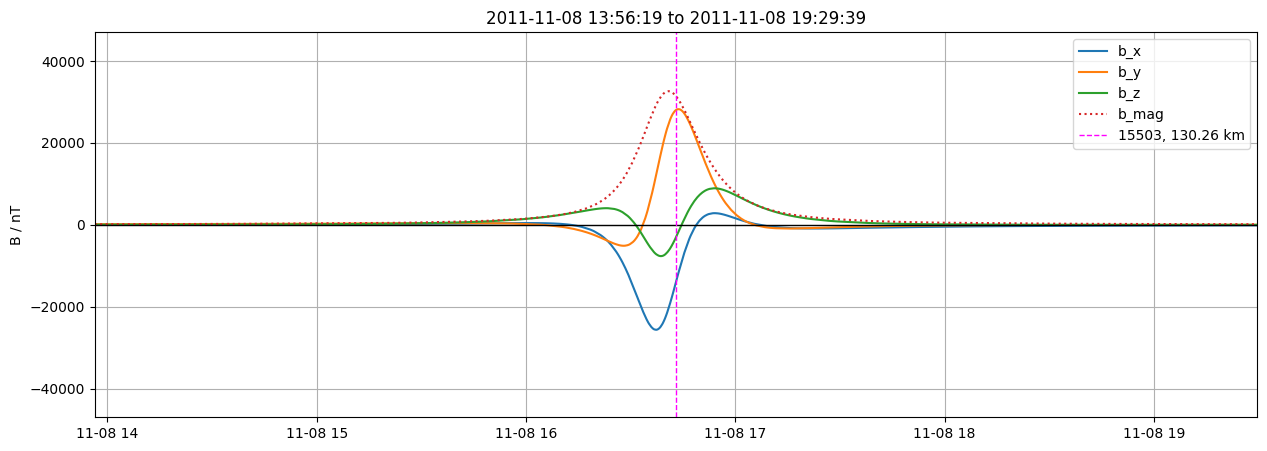

In [42]:
rcParams['figure.figsize'] = 15, 5

plt.plot(t,bx,label='b_x')
plt.plot(t,by,label='b_y')
plt.plot(t,bz,label='b_z')
plt.plot(t,bmag,label='b_mag',ls=':')

plt.xlim(spec['t'].values[0],spec['t'].values[-1])
plt.ylim(-maxb, maxb)
plt.ylabel('B / nT')
plt.axhline(0, lw=1, color='black')
plt.axvline(x = conj['conj-time'].iloc[index],lw=1,ls='--',color='magenta',label = str(conj['sat-ID'].iloc[index]) + ', ' + str(round(conj['conj-dist'].iloc[index], 2)) + ' km')
plt.grid()
plt.legend()
plt.title(str(t1) + ' to ' + str(t2))

In [43]:
%%time

# 'tle search' abbreviated as 'ts'
ts_buffer = 1 # in days
ts_e1 = d1 - timedelta(days=ts_buffer)
ts_e2 = d2 + timedelta(days=ts_buffer)

ts_list = findTLE(sat_id, ts_e1, ts_e2) # list of eligible TLEs

sat_tle = tle_select(ts_list, j_conj_time) # selecting the closest TLE

# SGP4 propagation
j_range = np.arange(j_sta, j_end, 1/86400)
r_sat = np.zeros((len(j_range),3))
for i in range(len(j_range)):
    r_sat[i,:] = Satrec.twoline2rv(sat_tle[0], sat_tle[1]).sgp4(j_range[i],0)[1]

sx_teme = r_sat[:,0]/r_e
sy_teme = r_sat[:,1]/r_e
sz_teme = r_sat[:,2]/r_e

# converting from TEME (TLE) to GSE (CLUSTER)
cc_time = np.arange(sta.timestamp(), end.timestamp())
sx, sy, sz = ConvertCoord(cc_time, sx_teme, sy_teme, sz_teme, 'teme', 'car', 'GSE', 'car', verbose=False)[:-1]
sx*=r_e
sy*=r_e
sz*=r_e

Converting 20000 positions into GSEcar coordinates...done in 41.9698 seconds.


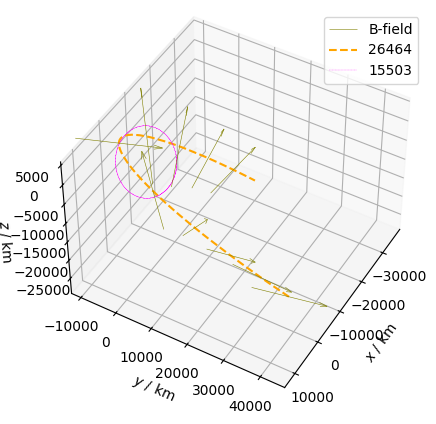

In [63]:
plt.figure()
ax = plt.axes(projection='3d')

p_int = 10000

plt.quiver(x[::p_int],y[::p_int],z[::p_int],bx[::p_int],by[::p_int],bz[::p_int],length=10000,arrow_length_ratio=0.2,normalize=True,color='olive',label='B-field',linewidths=0.4)
plt.quiver(x[::p_int],y[::p_int],z[::p_int],-bx[::p_int],-by[::p_int],-bz[::p_int],length=10000,arrow_length_ratio=0,normalize=True,color='olive',linewidths=0.4)
plt.plot(x,y,z,ls='--',c='orange',label='26464')
plt.plot(sx,sy,sz,lw=0.2,ls='--',c='magenta',label=str(conj['sat-ID'].iloc[index]))

ax.legend()
ax.set_xlabel('$x$ / km')
# ax.yaxis.set_rotate_label(False)
ax.set_ylabel('$y$ / km')
ax.set_zlabel('$z$ / km')

ax.view_init(45, 30)

In [73]:
# latitude, longitude and altitude at conjunction

conj_point = spec.sel(t=slice(conj_time-timedelta(seconds=1),conj_time+timedelta(seconds=1)))
lon_gdz, lat_gdz, al_gdz, units = ConvertCoord(pd.to_datetime(conj_point['t'].values[0]).value*1e-9, conj_point['bvec'].values[0,4]/r_e, conj_point['bvec'].values[0,5]/r_e, conj_point['bvec'].values[0,6]/r_e, 'GSE', 'car', 'GDZ', 'sph', verbose=False)

print('Latitude: ' + str(lat_gdz[0].round(2)) + ', longitude: ' + str(lon_gdz[0].round(2)) + ', altitude: ' + str(al_gdz[0].round(2)))

Latitude: 39.13, longitude: -125.58, altitude: 995.73
